In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects

In [3]:
PATH = Path('data/pascal/')
list(PATH.iterdir())

[PosixPath('data/pascal/tmp'),
 PosixPath('data/pascal/VOCdevkit'),
 PosixPath('data/pascal/pascal_train2012.json'),
 PosixPath('data/pascal/pascal_val2012.json'),
 PosixPath('data/pascal/pascal_val2007.json'),
 PosixPath('data/pascal/pascal_train2007.json'),
 PosixPath('data/pascal/pascal_test2007.json')]

In [4]:
train_keys = json.load((PATH/'pascal_train2007.json').open())
train_keys.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [5]:
IMAGES, ANNOTATIONS, CATEGORIES = ['images', 'annotations', 'categories']
train_keys[IMAGES][:5]

[{'file_name': '000012.jpg', 'height': 333, 'id': 12, 'width': 500},
 {'file_name': '000017.jpg', 'height': 364, 'id': 17, 'width': 480},
 {'file_name': '000023.jpg', 'height': 500, 'id': 23, 'width': 334},
 {'file_name': '000026.jpg', 'height': 333, 'id': 26, 'width': 500},
 {'file_name': '000032.jpg', 'height': 281, 'id': 32, 'width': 500}]

In [6]:
train_keys[ANNOTATIONS][:2]

[{'area': 34104,
  'bbox': [155, 96, 196, 174],
  'category_id': 7,
  'id': 1,
  'ignore': 0,
  'image_id': 12,
  'iscrowd': 0,
  'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]]},
 {'area': 13110,
  'bbox': [184, 61, 95, 138],
  'category_id': 15,
  'id': 2,
  'ignore': 0,
  'image_id': 17,
  'iscrowd': 0,
  'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]]}]

In [7]:
train_keys[CATEGORIES][:3]

[{'id': 1, 'name': 'aeroplane', 'supercategory': 'none'},
 {'id': 2, 'name': 'bicycle', 'supercategory': 'none'},
 {'id': 3, 'name': 'bird', 'supercategory': 'none'}]

In [8]:
# img = plt.imread(PATH/'VOCdevkit/Images')%
# %ls '{PATH}'/VOCdevkit/VOC2007/JPEGImages


jpegs = list( (PATH/'VOCdevkit/VOC2007/JPEGImages').iterdir());jpegs[:4]

[PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/007594.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/005682.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/005016.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/001930.jpg')]

data/pascal/VOCdevkit/VOC2007/JPEGImages/003004.jpg


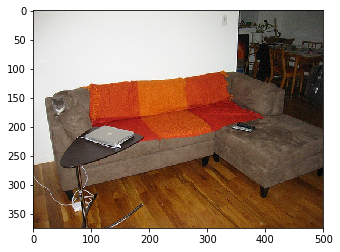

In [9]:
choice = np.random.choice(jpegs)
print(choice)
img = plt.imread(choice)
plt.imshow(img)

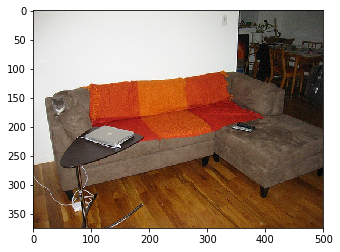

In [11]:
fig, ax = plt.subplots(figsize=None)
ax.imshow(img)


In [12]:
train_keys[ANNOTATIONS][:1]

[{'area': 34104,
  'bbox': [155, 96, 196, 174],
  'category_id': 7,
  'id': 1,
  'ignore': 0,
  'image_id': 12,
  'iscrowd': 0,
  'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]]}]

# 1.  DATA LOADER

In [13]:
train_annotations = collections.defaultdict(lambda:[])

In [14]:
train_annotations_dict = collections.defaultdict(lambda:[])
for o in train_keys[ANNOTATIONS]: 
    if not o['ignore']:
        image_id = o['image_id']
        bb = o['bbox']
        bb = np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])
        train_annotations_dict[image_id].append((bb,o['category_id']))
        
# train_keys[ANNOTATIONS][:1]

In [15]:
train_annotations_dict[12]


[(array([ 96, 155, 269, 350]), 7)]

In [16]:
def get_largest(b):
    if not b: raise Exception()
    b = sorted(b, key=lambda x: np.product(x[0][-2:]-x[0][:2]), reverse=True)
    return b[0]

In [17]:
largest_items = {a: get_largest(b) for a,b in train_annotations_dict.items() }

In [20]:
train_filenames_dict = {o['id']: o['file_name'] for o in train_keys[IMAGES]}; 
# train_filenames = train_keys[IMAGES] 

train_filenames_dict[17]

'000017.jpg'

In [21]:
# train_keys[CATEGORIES][:1]
categories_dict = {o['id']: o['name']for o in train_keys[CATEGORIES]}; categories_dict[1]

'aeroplane'

In [23]:
train_ids = [o['id'] for o in train_keys[IMAGES]]; train_ids[0]

12

In [25]:
IMG_PATH = PATH/'VOCdevkit/VOC2007/JPEGImages'; IMG_PATH

PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages')

In [26]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1],a[2]-a[0]])

def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])
    
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)
    
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)
    
def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], categories_dict[c], sz=16)

def draw_idx(i):
    im_a = train_annotations_dict[i]
    im = open_image(IMG_PATH/train_filenames_dict[i])
    print(im.shape)
    draw_im(im, im_a)

(375, 500, 3)


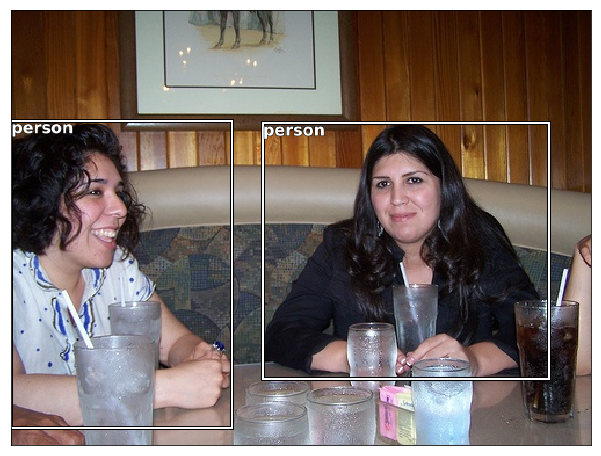

In [34]:
draw_idx(train_ids[7]); 

In [32]:
df = pd.DataFrame({'fn': [train_filenames_dict[o] for o in train_ids ], 
                   'cats': [largest_items[o][1] for o in train_ids]}, 
                  columns=['fn', 'cats'])

In [33]:
df.head()

,fn,cats
0,000012.jpg,7
1,000017.jpg,13
2,000023.jpg,15
3,000026.jpg,7
4,000032.jpg,1


In [43]:
images_folder = 'VOCdevkit/VOC2007/JPEGImages'

In [44]:
filename_category_csv = PATH/'tmp/cat.csv'
os.makedirs(PATH/'tmp',exist_ok=True)
df.to_csv(filename_category_csv, index=False) 

In [45]:
# ImageClassifierData.from_csv??

In [46]:
f_model = resnet34
sz=224
bs=64

In [47]:
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, crop_type=CropType.NO)

In [48]:
md = ImageClassifierData.from_csv(PATH, images_folder, filename_category_csv, tfms=tfms)

In [51]:
batch = next(iter(md.trn_dl)); batch  

[
 ( 0 , 0 ,.,.) = 
  -4.5898e-01 -4.5710e-01 -4.2722e-01  ...  -2.0498e+00 -2.0490e+00 -2.0571e+00
  -4.7096e-01 -4.6002e-01 -4.2671e-01  ...  -2.0976e+00 -2.1010e+00 -2.0791e+00
  -4.8056e-01 -4.7204e-01 -4.6481e-01  ...  -2.1158e+00 -2.1179e+00 -2.0825e+00
                  ...                   ⋱                   ...                
   1.3897e+00  1.3177e+00  1.2798e+00  ...   8.8289e-01  3.9654e-01  8.1460e-01
   1.1779e+00  1.2510e+00  1.4911e+00  ...   1.1849e+00  9.5073e-01  5.6044e-01
   1.3963e+00  1.3475e+00  1.2029e+00  ...   1.1933e+00  1.1704e+00  8.7054e-01
 
 ( 0 , 1 ,.,.) = 
   4.2190e-01  4.0120e-01  4.0207e-01  ...  -1.9711e+00 -1.9674e+00 -1.9736e+00
   4.0569e-01  3.9885e-01  4.0258e-01  ...  -2.0058e+00 -2.0104e+00 -1.9945e+00
   3.7857e-01  3.7235e-01  3.6375e-01  ...  -2.0263e+00 -2.0327e+00 -1.9963e+00
                  ...                   ⋱                   ...                
   1.4235e+00  1.3496e+00  1.3123e+00  ...   1.0791e+00  5.9196e-01  1.0330e+00


In [52]:
learn = ConvLearner.pretrained??

In [54]:
learn = ConvLearner.pretrained(f_model, md, metrics=[accuracy])

In [55]:
learn.opt_fn = optim.Adam

In [59]:
learn.fit(1e-2, 3)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      1.223502   0.601458   0.828876  
    1      0.854109   0.574793   0.831731                  
    2      0.662776   0.592452   0.834736                  



[0.5924521, 0.8347355797886848]